#### importing the relevant packages and loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.preprocessing import StandardScaler

In [55]:
X = pd.read_csv("dengue_features_train.csv")
y = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")

#### Pre Processing

In [3]:
def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

In [4]:
def extract_month(s):
    return int(s[5:7])

In [23]:
def pre_process(X, train = True):
    """
    Extracts the month out of date and converts it to a one hot
    Standardizes the numerical features
    Converts the city column to a boolean feature
    """
    # Converting the city column into a boolean, since we just have two cities
    is_sj = X.city == 'sj'

    #Extracting month from the date
    months = X.week_start_date.apply(extract_month)

    # Removing the dates info for now
    X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
    
    if train:
        # Dropping the rows with null values for now
        X.dropna(inplace=True)
    else:
        X.fillna(0,inplace=True)

    # Standardizing the data
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    # Adding the city boolean column
    X['is_sj'] = is_sj.loc[X.index]

    sliced_months = months.loc[X.index]
    # Month one hot features
    month_features = pd.get_dummies(sliced_months)
    X = X.join(month_features)

    # Alternatively use months as a discrete feature
    #X = X.join(sliced_months)
    
    return X

In [6]:
X = pre_process(X)

In [7]:
# Selecting y values corresponding to the filtered X values
y = y.total_cases.loc[X.index]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, shuffle = False)

#### Random Model

In [13]:
y_p = np.full(len(Y_test), np.mean(Y_train))

In [14]:
mean_absolute_error(Y_test, y_p)

18.120148312940305

In [15]:
mape(Y_test, y_p)

436.48118768988996

#### Baseline Model

In [16]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

In [17]:
mean_absolute_error(Y_test, Y_pred)

12.635846111002717

In [18]:
mape(Y_test, Y_pred)

251.79890294960933

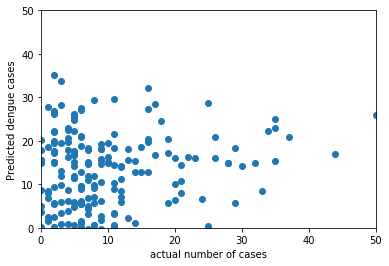

In [19]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### Feature Selection using RFE

In [ ]:
from sklearn.feature_selection import RFE

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select n attributes
rfe = RFE(model, 13)
rfe = rfe.fit(X, y)
X_Select = X.loc[:, rfe.support_]

# Split based on the newly selected features and train and test again
X_train, X_test, Y_train, Y_test = train_test_split(X_Select, y, shuffle = False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mean_absolute_error(Y_test, Y_pred)

#### L1

In [31]:
clf = linear_model.Lasso(alpha=0.5)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

8.198567106905848

In [32]:
mape(Y_test, Y_pred)

156.97701787409267

#### L2

In [12]:
clf = linear_model.Ridge(alpha = 44)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

7.969390105082307

In [30]:
mape(Y_test, Y_pred)

158.49460941010162

#### Submission

In [53]:
def submission(clf, rfe, filename = 'submission_1.csv'):
    test = pd.read_csv("dengue_features_test.csv")
    submission = test[['city', 'year', 'weekofyear']]
    X_test = pre_process(test, train =False)
    X_test = X_test.loc[:, rfe.support_]
    submission['total_cases'] = clf.predict(X_test).astype(int).clip(0)
    submission.to_csv(filename, index=False)

In [56]:
submission(clf, rfe)

/home/susmeet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
